In [2]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.dcgan as dcgan

### Setup CUDA / Multiprocessing related variables

In [3]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREATS = torch.get_num_threads()
    print("Number of Threats: ", NUM_THREATS)
else:
    NUM_THREATS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threats:  8


### Setup Parameters

In [4]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [5]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220915-clean.pkl")
OUT_PATH = path.join("dcgan-output")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 2
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Load dataset

In [6]:
# Poster subset:
GENRE=['Horror']
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=None
SORT='popularity'

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_THREATS, pin_memory=True)

Sample dataset:

The dataset has 18119 entries.


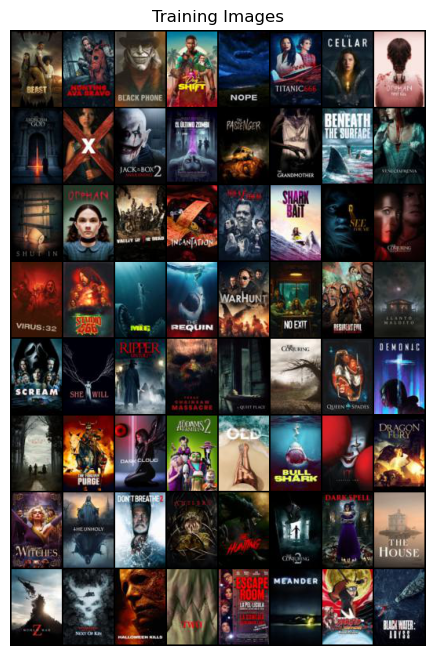

In [7]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [8]:
generator, discriminator = dcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [9]:
trainer = dcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

In [10]:
SHOW_GRAPHS = False

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, show_graphs=SHOW_GRAPHS)

[0/1]	Loss_D: 0.8529	Loss_G: 2.4285	D(x): 0.7113	D(G(z)): 0.3470 / 0.1021: 100%|██████████| 284/284 [00:29<00:00,  9.61it/s]
[1/1]	Loss_D: 0.7169	Loss_G: 2.9615	D(x): 0.6602	D(G(z)): 0.1804 / 0.0855: 100%|██████████| 284/284 [00:29<00:00,  9.76it/s]


### Show results

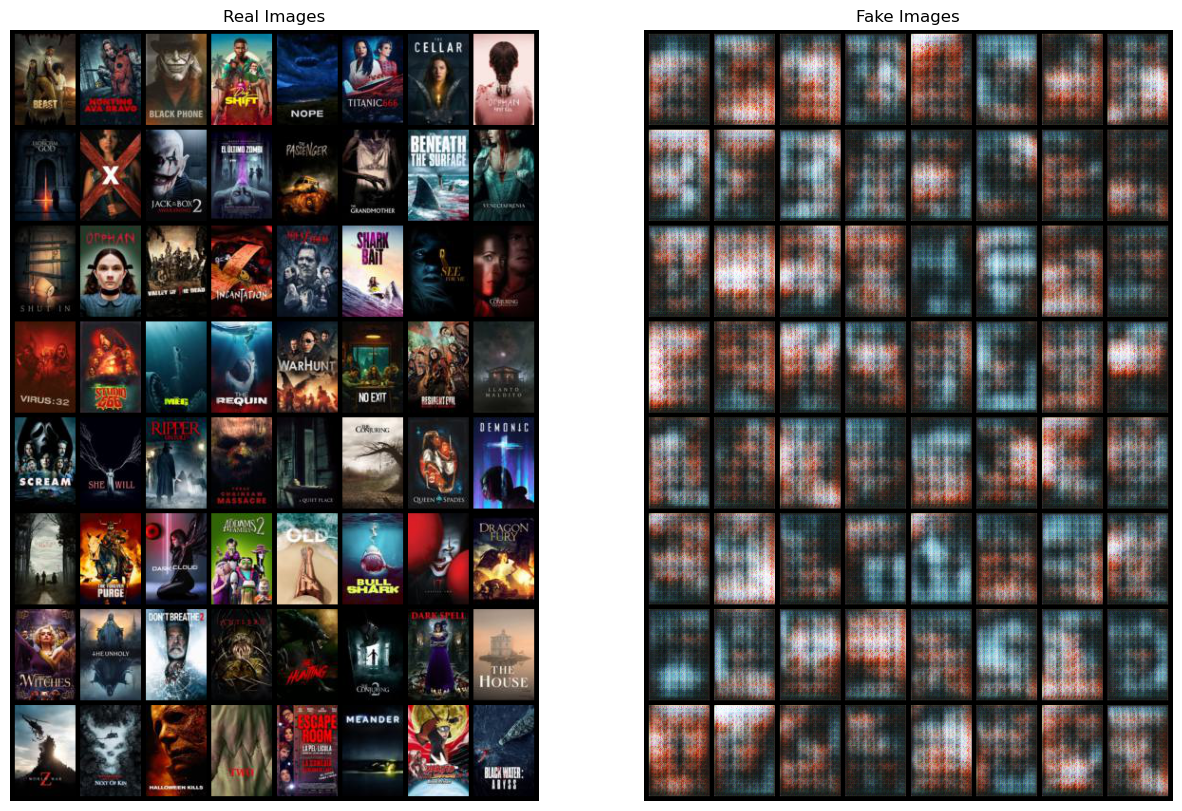

In [11]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))